# import & utils


In [2]:
import os

import jraph
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
from tqdm.auto import trange

pl.style.use("dark_background")


def np2pil(a):
    a = np.asarray(a)
    if a.dtype.kind == "f":
        a = np.uint8(a.clip(0, 1) * 255)

    return PIL.Image.fromarray(a)


def imshow(a):
    display(np2pil(a))


def zoom(a, k=2):
    return np.repeat(np.repeat(a, k, 1), k, 0)


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), "constant")
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a

In [3]:
import jax
import jax.numpy as jp
import optax
from flax import nnx

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [6]:
import logging

# Configure logging
log = logging.getLogger(__name__)

# Params

In [7]:
from boolean_nca_cc import generate_layer_sizes

In [8]:
input_n, output_n = 8, 8
arity = 4
layer_sizes = generate_layer_sizes(input_n, output_n, arity, layer_n=3)
loss_type = "l4"
n_gates = sum(group_n for group_n, _ in layer_sizes)

In [9]:
layer_sizes, n_gates


([(8, 1), (64, 4), (64, 4), (32, 2), (8, 1)], 176)

# Training


In [10]:
from boolean_nca_cc.circuits.model import gen_circuit
from boolean_nca_cc.circuits.tasks import get_task_data
from boolean_nca_cc.circuits.train import TrainState, train_step
from boolean_nca_cc.circuits.viz import evaluate_and_visualize

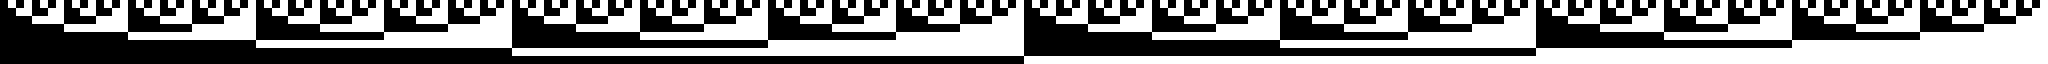

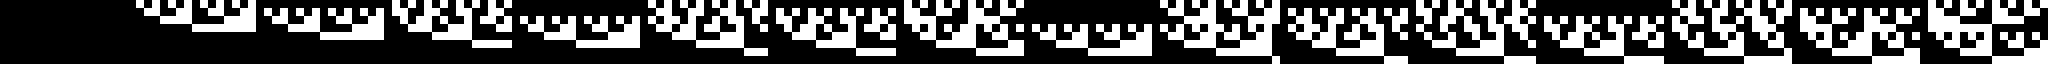

In [11]:
key = jax.random.PRNGKey(42)
wires, logitsbp = gen_circuit(key, layer_sizes, arity=arity)
opt = optax.adamw(1, 0.8, 0.8, weight_decay=1e-1)
state = TrainState(params=logitsbp, opt_state=opt.init(logitsbp))


case_n = 1 << input_n
x = jp.arange(case_n)
x, y0 = get_task_data("binary_multiply", case_n, input_bits=input_n, output_bits=output_n)

zoom_factor = 8
imshow(zoom(x.T, zoom_factor))
imshow(zoom(y0.T, zoom_factor))

## BackProp

In [12]:
loss_log_bp = []
aux_log_bp = []

In [13]:
from boolean_nca_cc.training.pool.structural_perturbation import (
    create_reproducible_knockout_pattern,
)

In [14]:
key = jax.random.PRNGKey(0)
gate_mask = create_reproducible_knockout_pattern(
    key=key,
    layer_sizes=layer_sizes,
    number_knokouts=n_gates // 3,
    input_n=input_n,
)

[m.shape for m in gate_mask], [m.mean() for m in gate_mask]

([(8,), (64,), (64,), (32,), (8,)],
 [Array(1., dtype=float32),
  Array(0.53125, dtype=float32),
  Array(0.6875, dtype=float32),
  Array(0.75, dtype=float32),
  Array(1., dtype=float32)])

In [15]:
pbar = trange(100)
for _i in pbar:
    loss, aux, state = train_step(
        state, opt, wires, x, y0, loss_type, do_train=True, gate_mask=None
    )
    loss_log_bp.append(loss)
    aux_log_bp.append(aux)
    pbar.set_postfix_str(
        f"loss: {loss.item():.3E}, accuracy: {aux['accuracy'].item():.2%}"
        + (
            f" | hard_loss: {aux['hard_loss'].item():.3E}, hard_accuracy: {aux['hard_accuracy'].item():.2%}"
            if "hard_loss" in aux
            else ""
        )
    )

  0%|          | 0/100 [00:00<?, ?it/s]

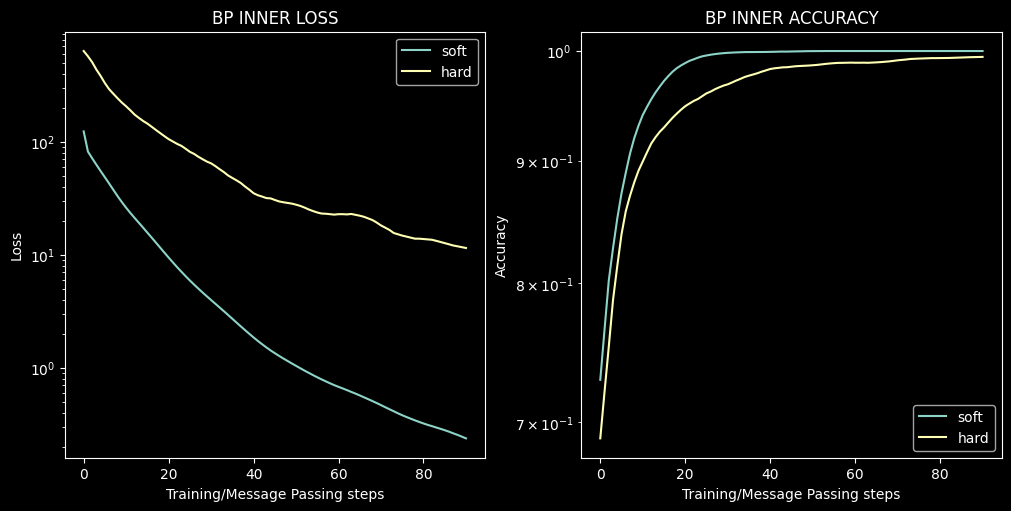

In [16]:
def plot_losses(loss_log, aux_log, figax=None, title=None, plot_accuracy=False, plot_hard=True):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    v = len(loss_log) // 10

    if not plot_accuracy:
        smooth_losses = np.convolve(loss_log, np.ones(v) / v, mode="valid")
        hard_losses = [aux["hard_loss"] for aux in aux_log]
        smooth_hard_losses = np.convolve(hard_losses, np.ones(v) / v, mode="valid")
        ax.plot(smooth_losses, label="soft")
        if plot_hard:
            ax.plot(jp.maximum(smooth_hard_losses, 1e-5), label="hard")
    else:
        accs = [aux["accuracy"] for aux in aux_log]
        smooth_accs = np.convolve(accs, np.ones(v) / v, mode="valid")
        ax.plot(smooth_accs, label="soft")
        hard_accs = [aux["hard_accuracy"] for aux in aux_log]
        smooth_hard_accs = np.convolve(hard_accs, np.ones(v) / v, mode="valid")
        if plot_hard:
            ax.plot(smooth_hard_accs, label="hard")

    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel("Training/Message Passing steps")
    ax.set_ylabel("Loss" if not plot_accuracy else "Accuracy")

    if title is not None:
        ax.set_title(title)


fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True)
plot_losses(loss_log_bp, aux_log_bp, (fig, axs[0]), title="BP INNER LOSS")
plot_losses(
    loss_log_bp,
    aux_log_bp,
    (fig, axs[1]),
    plot_accuracy=True,
    title="BP INNER ACCURACY",
)

In [17]:
bp_results = {
    "losses": loss_log_bp,
    "aux_log": aux_log_bp,
}

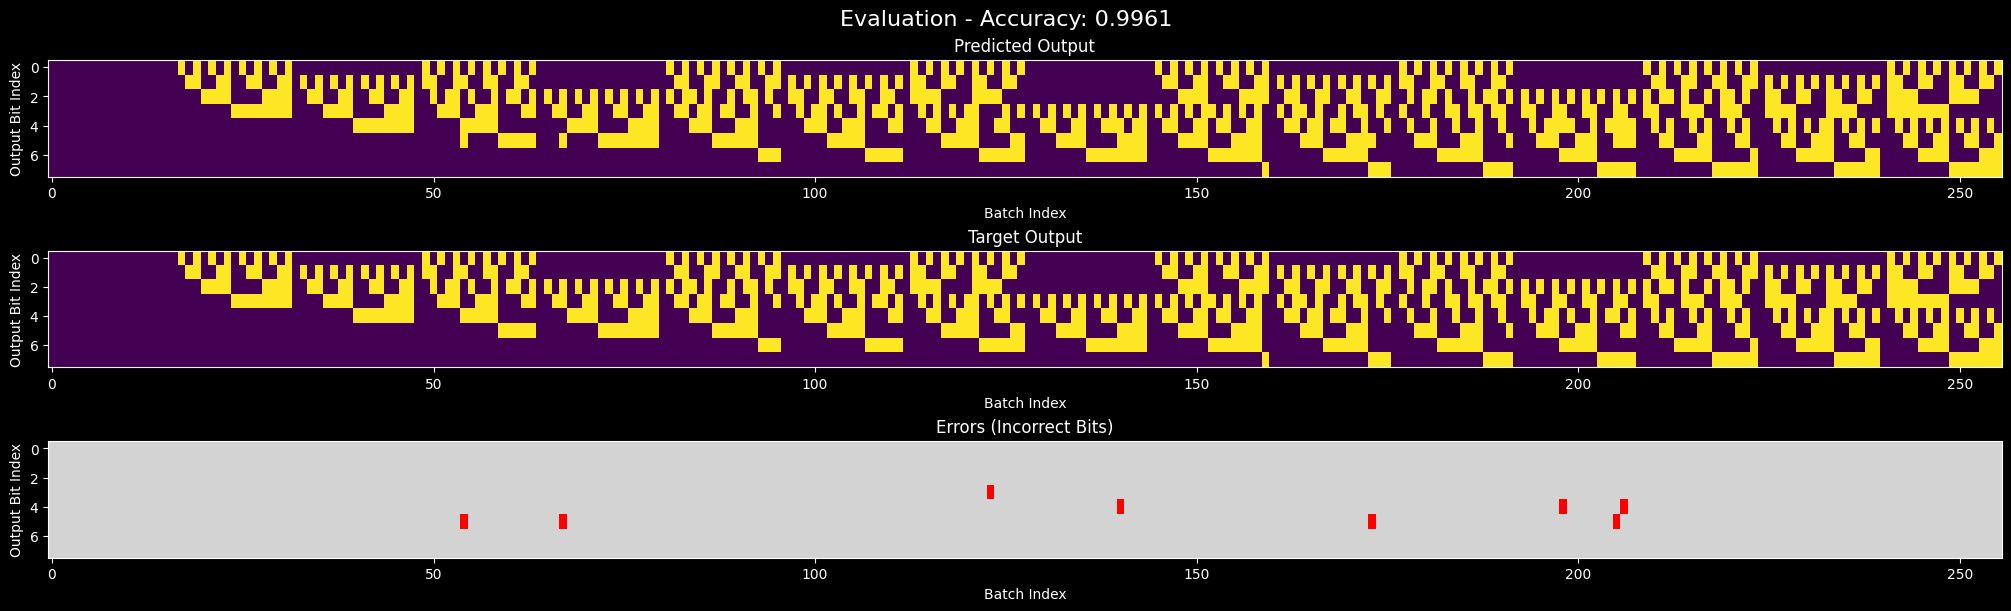

In [18]:
metrics = evaluate_and_visualize(state.params, wires, x, y0, hard=True)

In [19]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

## Models

In [20]:
from boolean_nca_cc.circuits.train import loss_f_l4
from boolean_nca_cc.models import (
    CircuitGNN,
    CircuitSelfAttention,
)
from boolean_nca_cc.training import get_loss_and_update_graph, train_model
from boolean_nca_cc.training.pool.structural_perturbation import layered_to_flat_mask
from boolean_nca_cc.training.utils import check_gradients
from boolean_nca_cc.utils import (
    build_graph,
    extract_logits_from_graph,
)


In [21]:
hidden_dim = 32
hidden_features = 32
n_message_steps = 1
key = jax.random.PRNGKey(42)
wires, logits = gen_circuit(key, layer_sizes, arity=arity)
loss, aux = loss_f_l4(logits, wires, x, y0)

flat_gate_mask = layered_to_flat_mask(gate_mask)

graph = build_graph(
    logits,
    wires,
    input_n,
    arity,
    circuit_hidden_dim=hidden_dim,
    loss_value=loss,
    gate_knockout_mask=gate_mask,
    knockout_strategy="no_receive",
)

In [22]:
set(np.where(np.array(flat_gate_mask) == 0.0)[0].tolist()).intersection(graph.receivers.tolist())

set()

In [23]:
from functools import partial

y_target = y0
random_loss_step = False


# Define loss function


@partial(nnx.jit, static_argnames=("n_message_steps",))
def loss_fn(model, graph, logits, wires, loss_key, n_message_steps=n_message_steps):
    # Store original shapes for reconstruction
    logits_original_shapes = [logit.shape for logit in logits]

    # Determine which scan function to use based on model type
    if isinstance(model, CircuitGNN):
        from boolean_nca_cc.models.gnn import run_gnn_scan_with_loss

        scan_fn = run_gnn_scan_with_loss
    elif isinstance(model, CircuitSelfAttention):
        from boolean_nca_cc.models.self_attention import (
            run_self_attention_scan_with_loss,
        )

        scan_fn = run_self_attention_scan_with_loss
    else:
        raise ValueError(f"Unknown model type: {type(model)}")

    # Run scan for all steps, computing loss and updating graph at each step
    final_graph, step_outputs = scan_fn(
        model=model,
        graph=graph,
        num_steps=n_message_steps,
        logits_original_shapes=logits_original_shapes,
        wires=wires,
        x_data=x,
        y_data=y_target,
        loss_type=loss_type,
        layer_sizes=layer_sizes,
    )

    # Choose which step to use for loss computation
    if random_loss_step:
        loss_step = jax.random.randint(loss_key, (1,), 0, n_message_steps)[0]

    else:
        loss_step = -1

    final_graph, final_loss, final_logits, final_aux = jax.tree.map(
        lambda x: x[loss_step], step_outputs
    )
    return final_loss, (final_aux, final_graph, final_logits, loss_step)


@partial(nnx.jit, static_argnames=("n_message_steps",))
def loss_fn_no_scan(model, graph, logits, wires, loss_key, n_message_steps=n_message_steps):
    # Choose which step to use for loss computation
    if random_loss_step:
        n_loss_step = jax.random.randint(loss_key, (1,), 0, n_message_steps)[0]

    else:
        n_loss_step = n_message_steps - 1

    all_results = []

    for i in range(n_message_steps):
        graph = model(graph)
        graph, loss, logits, aux = get_loss_and_update_graph(
            graph=graph,
            logits_original_shapes=[l.shape for l in logits],
            wires=wires,
            x_data=x,
            y_data=y_target,
            loss_type=loss_type,
            layer_sizes=layer_sizes,
        )
        all_results.append((loss, aux, graph, logits))

    # Stack all results using jax.tree_map
    stacked_results = jax.tree.map(lambda *args: jp.stack(args), *all_results)

    # Index at n_loss_step
    final_loss, final_aux, final_graph, final_logits = jax.tree.map(
        lambda x: x[n_loss_step], stacked_results
    )

    return final_loss, (final_aux, final_graph, final_logits, n_loss_step)

### Schedulers

#### lr

In [ ]:
from boolean_nca_cc.training.schedulers import get_learning_rate_schedule

In [ ]:
lr_scheduler = get_learning_rate_schedule(
    lr_scheduler="linear_warmup",
    lr_scheduler_params={
        "exponent": 20,
        "warmup_steps_factor": 50,
        "alpha": 1e-2,
        "lr_warmup_start": 1e-6,
    },
    learning_rate=4e-4,
    epochs=2**16,
)

In [ ]:
steps = list(range(1, 2**16, 2**8))
plt.plot(steps, [lr_scheduler(i) for i in steps])
plt.yscale("log")

#### loss step

In [ ]:
from boolean_nca_cc.training.schedulers import get_step_beta

In [ ]:
n_steps = 50
loss_key = jax.random.PRNGKey(42)
batch_keys = jax.random.split(loss_key, 1024)
random_steps = jax.vmap(
    lambda key: jax.vmap(get_step_beta, in_axes=(0, None, 0, None, None))(
        jax.random.split(key, 100), n_steps, jp.linspace(0.0, 1.0, 100), 10, 0.1
    )
)(batch_keys)

In [ ]:
plt.plot(random_steps.mean(0))
plt.yticks(np.arange(0, 50, 2))
plt.xlabel("Training progress")
plt.ylabel("Average step trained")
plt.title("Average step over 1024 batches")
plt.show()

In [ ]:
fi, axs = plt.subplots(1, 5, figsize=(10, 2), sharey=False, sharex=True)
for progress, ax in zip(np.linspace(0.0, 100, len(axs), dtype=int), axs, strict=False):
    ax.hist(random_steps[:, progress], bins=np.arange(0, 50, 1))
    ax.set_title(f"Progress: {progress}")
    ax.set_xlabel("# Steps")

plt.show()

#### pool reset

In [ ]:
from boolean_nca_cc.training.pool.pool_evolution_simulator import (
    plot_pool_evolution,
    simulate_pool_reset_evolution,
)

In [ ]:
pool_size = 2048
epochs = 2**16
n_message_steps = 5
reset_pool_fraction = 0.1
reset_pool_interval = 128
use_beta_loss_step = False
reset_interval_schedule = None
seed = 42
meta_batch_size = 64

pool_results = simulate_pool_reset_evolution(
    pool_size=pool_size,
    epochs=epochs,
    n_message_steps=n_message_steps,
    reset_pool_fraction=reset_pool_fraction,
    reset_pool_interval=reset_pool_interval,
    reset_strategy="steps_biased",  # Focus on steps_biased (mock run)
    use_beta_loss_step=use_beta_loss_step,
    reset_interval_schedule=reset_interval_schedule,
    seed=seed,
    meta_batch_size=meta_batch_size,
    jump_size=32,
)

Starting pool evolution simulation for 65536 epochs (jump size: 32)


Simulating pool evolution:   0%|          | 0/2049 [00:00<?, ?it/s]

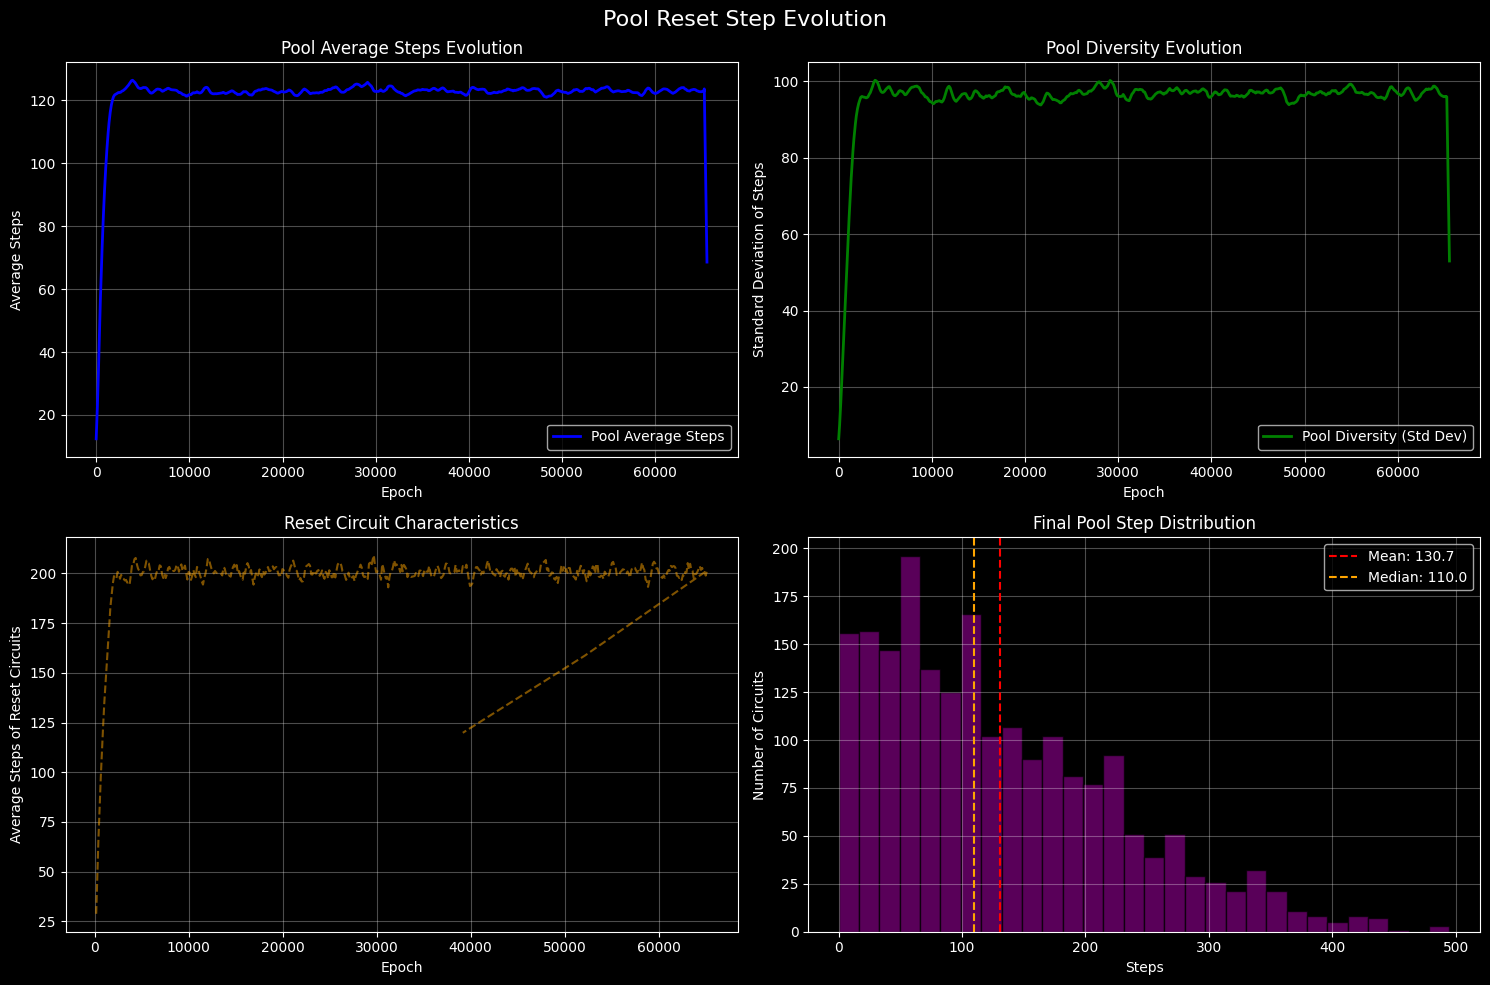

In [ ]:
plot_pool_evolution(pool_results)

### GNN

In [ ]:
gnn = CircuitGNN(
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    use_attention=False,
    arity=arity,
)

opt_fn = optax.adamw(1e-4, weight_decay=1e-5)
opt = nnx.Optimizer(gnn, opt_fn)

In [ ]:
from functools import partial

loss_fn_partial = partial(
    loss_fn,
    graph=graph,
    logits=logits,
    wires=wires,
    loss_key=jax.random.PRNGKey(42),
    n_message_steps=1,
)

(loss, aux), grads = nnx.value_and_grad(loss_fn_partial, has_aux=True)(gnn)
opt.update(grads)
(loss, aux), grads = nnx.value_and_grad(loss_fn_partial, has_aux=True)(gnn)
assert any(jax.tree.leaves(jax.tree.map(lambda x: x.any(), grads))), "No grads"

#### Training

In [ ]:
gnn_results = train_model(
    key=0,
    init_model=gnn,
    # CIRCUIT PARAMS
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    # TRAINING PARAMS
    epochs=2**13,
    n_message_steps=1,
    meta_batch_size=256,
    # WIRING MODE PARAMS
    wiring_mode="random",
    wiring_fixed_key=jax.random.PRNGKey(42),
    # LOSS PARAMS
    loss_type="l4",
    # OPTIMIZER PARAMS
    learning_rate=1e-3,
    weight_decay=1e-5,
    # LEARNING RATE SCHEDULER
    lr_scheduler="linear_warmup",
    # Model Params
    hidden_dim=hidden_dim,
    # POOL PARAMS : current mean avg of 100 steps before reset
    pool_size=1024,
    reset_pool_fraction=0.075,
    reset_pool_interval=2**5,
    # metric used to reset pool instances in priority : loss / "age" / combined
    reset_strategy="combined",
)

In [ ]:
try:
    gnn_results["model"] = nnx.state(gnn_results["model"])
    gnn_results["optimizer"] = nnx.state(gnn_results["optimizer"])
except ValueError:
    print("already converted")
    pass

In [ ]:
# save gnn_results
import pickle

with open("gnn_results.pkl", "wb") as f:
    pickle.dump(gnn_results, f)

In [ ]:
# recreate aux in old format
aux_log = [
    {
        "accuracy": accuracies,
        "hard_accuracy": hard_acc,
        "hard_loss": hard_loss,
    }
    for accuracies, hard_acc, hard_loss in zip(
        gnn_results["accuracies"],
        gnn_results["hard_accuracies"],
        gnn_results["hard_losses"],
        strict=False,
    )
]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True)
plot_losses(gnn_results["losses"], aux_log, (fig, axs[0]), title="META LOSS", plot_hard=True)
plot_losses(
    gnn_results["losses"],
    aux_log,
    (fig, axs[1]),
    plot_accuracy=True,
    title="META ACCURACY",
    plot_hard=True,
)

In [ ]:
v = len(gnn_results["reset_steps"]) // 10
plt.plot(np.convolve(gnn_results["reset_steps"], np.ones(v) / v, mode="valid"))

In [ ]:
# Get the inner loop losses
from boolean_nca_cc.training.evaluation import evaluate_model_stepwise

In [ ]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
print(wires_gnn)
graph = build_graph(logits_gnn, wires_gnn, input_n, arity, hidden_dim=hidden_dim, loss_value=loss)

In [ ]:
for i in range(20):
    graph = gnn(graph)

In [ ]:
final_logits = extract_logits_from_graph(graph, [l.shape for l in logits_gnn])

In [ ]:
metrics = evaluate_and_visualize(final_logits, wires, x, y0, hard=True)

In [ ]:
step_metrics = evaluate_model_stepwise(
    gnn,
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=100,
    arity=arity,
    hidden_dim=hidden_dim,
    loss_type="l4",
)

In [ ]:
aux_log_stepwise = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics["soft_accuracy"],
        step_metrics["hard_accuracy"],
        step_metrics["hard_loss"],
        strict=False,
    )
]

In [ ]:
step_metrics.keys()

In [ ]:
gnn_log_results = {
    "losses": step_metrics["soft_loss"],
    "aux_log": aux_log_stepwise,
}

In [ ]:
# Compare GNN and BP

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey="row", sharex="col", constrained_layout=True)

for method, axs_method, results in zip(
    ["GNN", "BP"], axs.T, [gnn_log_results, bp_results], strict=False
):
    for metric, ax in zip(["loss", "accuracy"], axs_method, strict=False):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )

#### Pool

In [ ]:
from boolean_nca_cc.training.pool import GraphPool, initialize_graph_pool

In [ ]:
init_pool = initialize_graph_pool(
    jax.random.PRNGKey(42),
    pool_size=1024,
    # circuit params
    layer_sizes=layer_sizes,
    arity=arity,
    input_n=input_n,
    # graph params
    hidden_dim=hidden_dim,
    loss_value=loss,
    wiring_mode="fixed",
)

In [ ]:
init_pool.wires[0][3], init_pool.wires[0][2]

In [ ]:
idxs, graphs, batch_of_wires, batch_of_logits = init_pool.sample(jax.random.PRNGKey(42), 16)

In [ ]:
graphs.nodes["logits"].sum(), idxs

In [ ]:
losses, updated_graphs = nnx.vmap(loss_fn, in_axes=(None, 0, 0))(gnn, graphs, batch_of_wires)

In [ ]:
updated_graphs.nodes["logits"].sum(), idxs

In [ ]:
updated_batch_of_logits = jax.vmap(extract_logits_from_graph, in_axes=(0, None))(
    updated_graphs, [l.shape[1:] for l in batch_of_logits]
)

In [ ]:
new_pool = init_pool.update(idxs, updated_graphs)

In [ ]:
new_idxs, new_graphs, new_batch_of_wires, new_batch_of_logits = new_pool.sample(
    jax.random.PRNGKey(42), 16
)

In [ ]:
(
    new_graphs.nodes["logits"].sum(),
    sum(jax.tree.map(lambda x: x.sum(), new_batch_of_logits)),
)

# Update cprrect

In [ ]:
new_pool = initialize_graph_pool(
    jax.random.PRNGKey(42),
    pool_size=1024,
    # circuit params
    layer_sizes=layer_sizes,
    arity=arity,
    input_n=input_n,
    # graph params
    hidden_dim=hidden_dim,
    loss_value=loss,
)

In [ ]:
init_pool.reset_fraction(
    jax.random.PRNGKey(43), 0.1, new_pool.graphs, new_pool.wires, new_pool.logits
)

In [ ]:
first_graph = jax.tree.map(lambda x: x[0], new_graphs)
first_graph.nodes["logits"].shape

first_logits = extract_logits_from_graph(first_graph, [l.shape[1:] for l in batch_of_logits])
sum(jax.tree.map(lambda x: x.sum(), first_logits)), first_graph.nodes["logits"].sum()

### Attention

In [ ]:
attn = CircuitSelfAttention(
    circuit_hidden_dim=hidden_dim,
    num_heads=8,
    num_layers=1,
    arity=arity,
    dropout_rate=0.1,
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    n_node=int(graph.n_node[0]),
    zero_init=False,
    re_zero_update=True,
)

opt_fn = optax.adamw(1e-3, weight_decay=1e-5)
opt = nnx.Optimizer(attn, opt_fn)

In [ ]:
nodes, edges, receivers, senders, globals_, n_node, n_edge = graph


In [ ]:
attn_mask = attn._create_attention_mask(
    graph.senders,
    graph.receivers,
)

Text(0.5, 1.0, 'Attention Mask, sum 914')

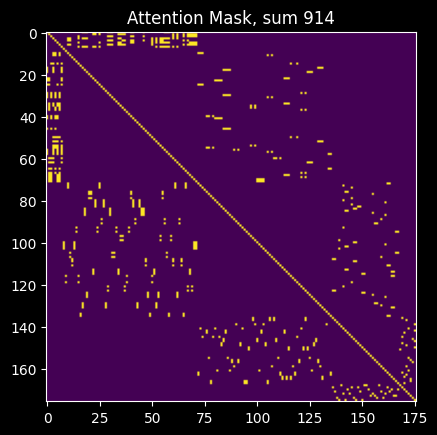

In [ ]:
plt.imshow(attn_mask.squeeze())

plt.title(f"Attention Mask, sum {attn_mask.sum()}")

In [ ]:
num_steps = 2

(loss, (final_aux, final_graph, final_logits, n_loss_step)), grads = nnx.value_and_grad(
    loss_fn_no_scan, has_aux=True
)(
    attn,
    graph,
    logitsbp,
    wires,
    loss_key=jax.random.PRNGKey(42),
    n_message_steps=num_steps,
)

opt.update(grads)
check_gradients(grads)

All 24 parameters have non-zero gradients


True

In [ ]:
final_graph.nodes["logits"][final_graph.nodes["layer"] == 0]

Array([[ 6.69218460e-03, -1.78283692e-04,  5.78121655e-03,
        -5.93629200e-03,  1.23177450e-02,  8.59187730e-03,
        -6.30471762e-03,  6.19286299e-03, -5.21459151e-04,
        -5.85671421e-03, -1.46329403e-03, -5.27900876e-04,
         3.03000817e-03,  1.02940258e-02, -3.90369771e-03,
        -6.19569328e-03],
       [ 7.08162226e-03,  8.20640591e-04,  7.71600800e-03,
        -4.93574329e-03,  1.30147468e-02,  8.13336764e-03,
        -5.72910532e-03,  3.42587987e-03, -3.69390845e-03,
        -2.70432280e-03, -2.85352813e-03, -2.75632693e-03,
         1.50618050e-03,  9.89315566e-03,  2.22383300e-04,
        -4.70825937e-03],
       [ 1.00560915e-02,  2.80971429e-03,  7.60138128e-03,
        -3.45518393e-03,  1.43038752e-02,  9.75493155e-03,
        -5.52479830e-03,  1.38422614e-03, -4.71344078e-03,
        -4.32018144e-03, -2.29724287e-03, -2.28919880e-03,
         3.11236829e-03,  1.10443169e-02,  1.86370441e-03,
        -3.95521615e-03],
       [ 1.29592093e-02, -1.59527874e

In [ ]:
final_graph.nodes["logits"][final_graph.nodes["gate_knockout_mask"] == 0]

Array([[-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -10., -10., -10.],
       [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10., -10., -1

In [ ]:
attn_results = train_model(
    key=0,
    init_model=attn,
    # CIRCUIT PARAMS
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    # TRAINING PARAMS
    epochs=2**13,
    n_message_steps=5,
    meta_batch_size=16,
    # WIRING MODE PARAMS
    wiring_mode="fixed",
    wiring_fixed_key=jax.random.PRNGKey(42),
    # LOSS PARAMS
    loss_type="l4",
    # OPTIMIZER PARAMS
    learning_rate=2e-4,
    weight_decay=1e-5,
    # LEARNING RATE SCHEDULER
    lr_scheduler="linear_warmup",
    # Model Params
    circuit_hidden_dim=hidden_dim,
    # POOL PARAMS : current mean avg of 100 steps before reset
    pool_size=1024,
    reset_pool_fraction=0.5,
    reset_pool_interval=32,
    # metric used to reset pool instances in priority : loss / "age" / combined
    reset_strategy="combined",
    # Periodic evaluation
    periodic_eval_enabled=False,
    periodic_eval_interval=512,
    periodic_eval_batch_size=64,
)

NameError: name 'train_model' is not defined

In [ ]:
# recreate aux in old format
attn_results_log = [
    {
        "accuracy": accuracies,
        "hard_accuracy": hard_acc,
        "hard_loss": hard_loss,
    }
    for accuracies, hard_acc, hard_loss in zip(
        attn_results["accuracies"],
        attn_results["hard_accuracies"],
        attn_results["hard_losses"],
        strict=False,
    )
]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True)
plot_losses(
    attn_results["losses"],
    attn_results_log,
    (fig, axs[0]),
    title="META LOSS",
    plot_hard=True,
)
plot_losses(
    attn_results["losses"],
    attn_results_log,
    (fig, axs[1]),
    plot_accuracy=True,
    title="META ACCURACY",
    plot_hard=True,
)

In [ ]:
# Get the inner loop losses
from boolean_nca_cc.training.evaluation import evaluate_model_stepwise

In [ ]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
step_metrics_attn = evaluate_model_stepwise(
    attn,
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=100,
    arity=arity,
    hidden_dim=hidden_dim,
    loss_type="l4",
    layer_sizes=layer_sizes,
)

In [ ]:
aux_log_stepwise_attn = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics_attn["soft_accuracy"],
        step_metrics_attn["hard_accuracy"],
        step_metrics_attn["hard_loss"],
        strict=False,
    )
]

In [ ]:
step_metrics_attn.keys()

In [ ]:
attn_log_results = {
    "losses": step_metrics_attn["soft_loss"],
    "aux_log": aux_log_stepwise_attn,
}

In [ ]:
# Compare GNN and BP

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey="row", sharex="col", constrained_layout=True)

for method, axs_method, results in zip(
    ["ATTN", "BP"], axs.T, [attn_log_results, bp_results], strict=False
):
    for metric, ax in zip(["loss", "accuracy"], axs_method, strict=False):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )

## WANDB

In [24]:
# Configure logging to see detailed output from load_best_model_from_wandb
from boolean_nca_cc.training.checkpointing import configure_notebook_logging

# Enable logging in the notebook
configure_notebook_logging()

print("Logging is now configured! You'll see detailed progress when loading models.")


Logging configured for notebooks. Level: INFO
Logging is now configured! You'll see detailed progress when loading models.


In [40]:
from boolean_nca_cc.training.checkpointing import load_best_model_from_wandb

loaded_model, loaded_dict, loaded_config = load_best_model_from_wandb(
    filters={
        "config.circuit.input_bits": 8,
        "config.circuit.output_bits": 8,
        "config.circuit.arity": 4,
        "config.circuit.num_layers": 3,
        "config.model.type": "self_attention",
        "config.circuit.task": "binary_multiply",
        "config.training.wiring_mode": "random",
    },
    select_by_best_metric=False,
    metric_name="training/hard_accuracy",
    use_cache=False,
    force_download=True,
    filename="latest_checkpoint",
    run_from_last=2,
)

2025-07-31 20:07:29,839 - boolean_nca_cc.training.checkpointing - INFO - Looking for runs with filters: {'config.circuit.input_bits': 8, 'config.circuit.output_bits': 8, 'config.circuit.arity': 4, 'config.circuit.num_layers': 3, 'config.model.type': 'self_attention', 'config.circuit.task': 'binary_multiply', 'config.training.wiring_mode': 'random'}


2025-07-31 20:07:31,088 - boolean_nca_cc.training.checkpointing - INFO - Found 5 matching runs.
2025-07-31 20:07:31,089 - boolean_nca_cc.training.checkpointing - INFO - Using run_from_last=2 to select run.
2025-07-31 20:07:31,090 - boolean_nca_cc.training.checkpointing - INFO - Selected run: woven-water-977 (ID: zd2eydh2)
2025-07-31 20:07:31,091 - boolean_nca_cc.training.checkpointing - INFO - Checking for local checkpoint at: saves/run_zd2eydh2/latest_checkpoint.pkl
2025-07-31 20:07:31,092 - boolean_nca_cc.training.checkpointing - INFO - Force download enabled, skipping local cache.
2025-07-31 20:07:31,092 - boolean_nca_cc.training.checkpointing - INFO - Retrieving artifacts...
2025-07-31 20:07:31,227 - boolean_nca_cc.training.checkpointing - INFO - Available artifacts:
2025-07-31 20:07:31,762 - boolean_nca_cc.training.checkpointing - INFO -   - run-zd2eydh2-poolscatter_table-43c1adb1a626cdcd94e2bcf3ef7ee822:v0
2025-07-31 20:07:31,762 - boolean_nca_cc.training.checkpointing - INFO -  

Instantiating model using config: boolean_nca_cc.models.CircuitSelfAttention
Computed n_nodes for CircuitSelfAttention: 176
Successfully instantiated model: CircuitSelfAttention


In [41]:
from boolean_nca_cc.circuits.tasks import get_task_data

In [42]:
key = jax.random.PRNGKey(420)
input_n, output_n, arity, layer_n = (
    loaded_config.circuit.input_bits,
    loaded_config.circuit.output_bits,
    loaded_config.circuit.arity,
    loaded_config.circuit.num_layers,
)

case_n = 1 << input_n
x = jp.arange(case_n)
x, y0 = get_task_data(loaded_config.circuit.task, case_n, input_bits=input_n, output_bits=output_n)
# x, y0 = get_task_data("binary_multiply", case_n, input_bits=input_n, output_bits=output_n)

circuit_hidden_dim = loaded_config.model.circuit_hidden_dim
loss_type = loaded_config.training.loss_type
layer_sizes = generate_layer_sizes(input_n, output_n, arity, layer_n=layer_n)
wires, logits = gen_circuit(key, layer_sizes, arity=arity)
graph = build_graph(
    logits, wires, input_n, arity, circuit_hidden_dim=circuit_hidden_dim, loss_value=0
)


In [43]:
updated_graph = loaded_model(graph)

In [44]:
updated_graph.nodes["logits"]

Array([[-0.22793375, -0.42960182, -0.9055309 , ...,  0.4727651 ,
        -0.15638869, -0.3147668 ],
       [ 0.03425069,  0.53160447, -0.2829208 , ...,  0.7765598 ,
        -0.06318001, -0.7030381 ],
       [-0.01318288,  0.3480286 , -0.26669034, ...,  0.55149233,
         0.02434682, -0.38800704],
       ...,
       [-0.17531681, -0.15334201,  0.515394  , ..., -0.69200325,
        -0.5669644 , -0.50036526],
       [ 0.3909495 ,  0.27440047,  0.745353  , ..., -0.55858946,
        -0.63064337, -0.6522887 ],
       [-0.01950598,  0.47167444,  0.5076568 , ..., -0.6633363 ,
        -0.87556314, -0.68246794]], dtype=float32)

In [45]:
from boolean_nca_cc.training.eval_datasets import (
    create_unified_evaluation_datasets,
    evaluate_circuits_in_chunks,
)
from boolean_nca_cc.training.evaluation import (
    evaluate_model_stepwise_batched,
)

# Create unified evaluation datasets
eval_datasets = create_unified_evaluation_datasets(
    evaluation_base_seed=loaded_config.test_seed,
    training_wiring_mode=loaded_config.training.wiring_mode,
    training_initial_diversity=loaded_config.training.initial_diversity,
    layer_sizes=layer_sizes,
    arity=arity,
    eval_batch_size=loaded_config.eval.batch_size,
)

2025-07-31 20:08:24,337 - boolean_nca_cc.training.eval_datasets - INFO - Creating unified evaluation datasets (base_seed=42)
2025-07-31 20:08:24,338 - boolean_nca_cc.training.eval_datasets - INFO - Training config: mode=random, diversity=256
2025-07-31 20:08:24,342 - boolean_nca_cc.training.eval_datasets - INFO - Creating OUT-of-distribution evaluation circuits...


2025-07-31 20:08:24,420 - boolean_nca_cc.training.eval_datasets - INFO - Unified Evaluation Datasets:
  - IN-distribution: None circuits (matches training: mode=random, diversity=256)
  - OUT-of-distribution: 256 circuits (random wiring)



In [46]:
step_metrics = evaluate_circuits_in_chunks(
    eval_fn=evaluate_model_stepwise_batched,
    wires=eval_datasets.out_of_distribution_wires,
    logits=eval_datasets.out_of_distribution_logits,
    target_chunk_size=eval_datasets.target_batch_size,
    model=loaded_model,
    x_data=x,
    y_data=y0,
    input_n=input_n,
    arity=arity,
    circuit_hidden_dim=circuit_hidden_dim,
    n_message_steps=100,
    loss_type=loss_type,
    layer_sizes=layer_sizes,
)

In [47]:
aux_log_stepwise = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics["soft_accuracy"],
        step_metrics["hard_accuracy"],
        step_metrics["hard_loss"],
        strict=False,
    )
]

In [48]:
model_log_results = {
    "losses": step_metrics["soft_loss"],
    "aux_log": aux_log_stepwise,
}

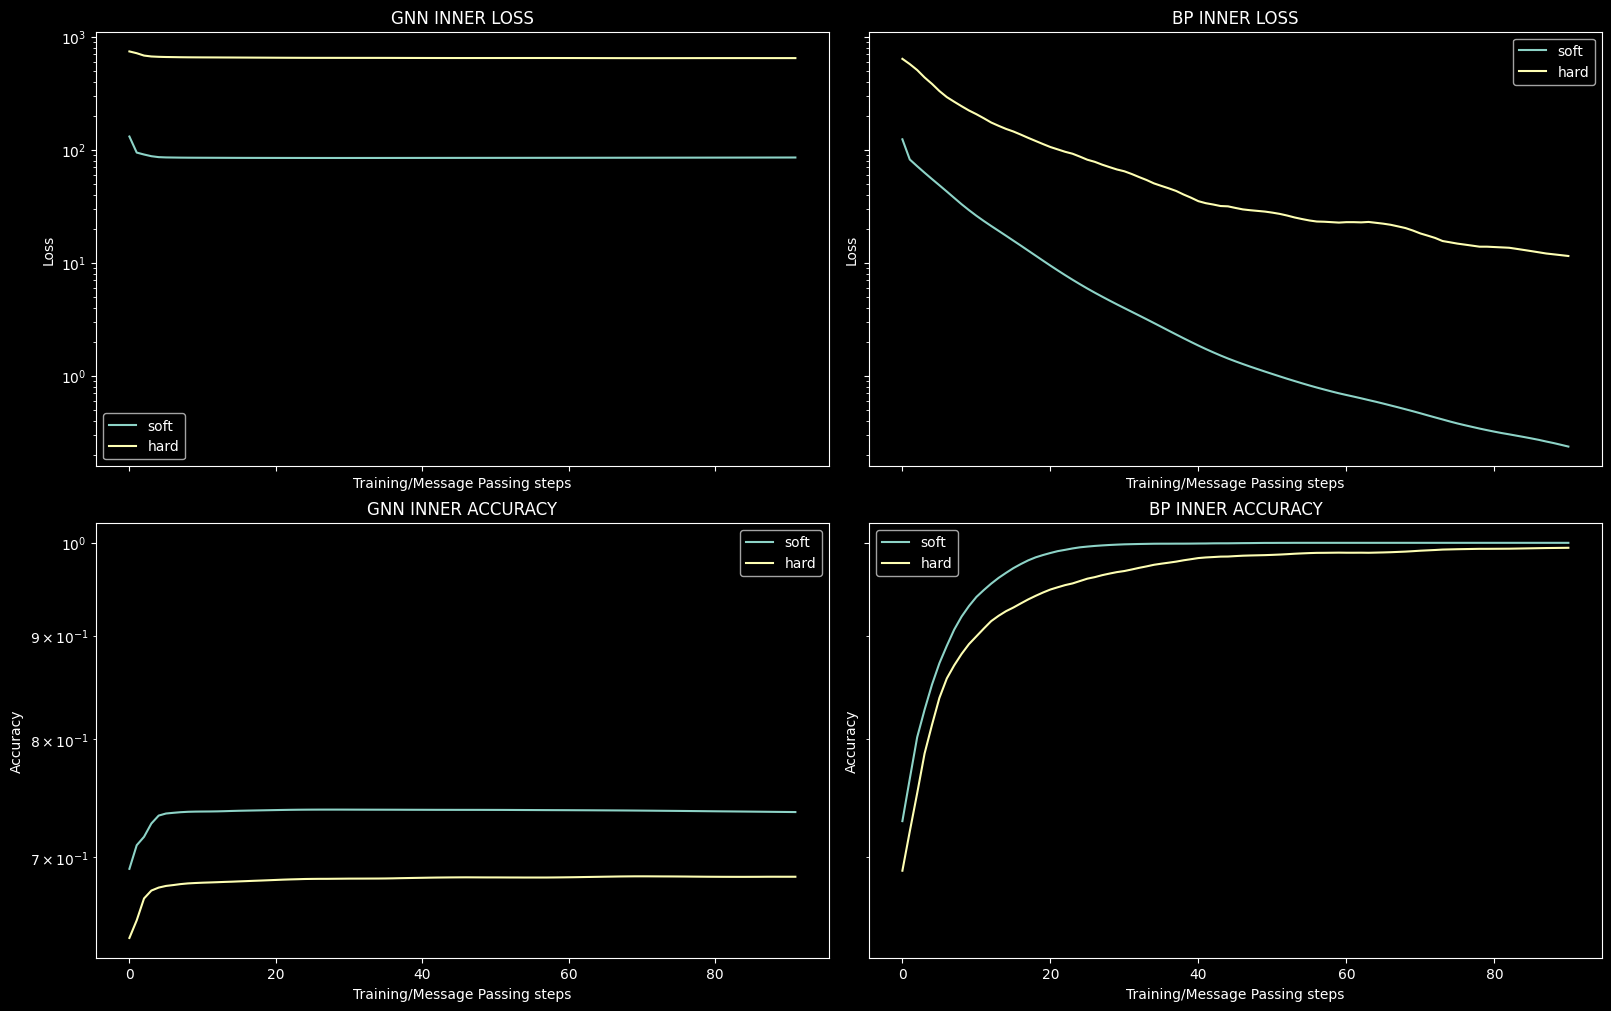

In [49]:
# Compare GNN and BP

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey="row", sharex="col", constrained_layout=True)

for method, axs_method, results in zip(
    ["GNN", "BP"], axs.T, [model_log_results, bp_results], strict=False
):
    for metric, ax in zip(["loss", "accuracy"], axs_method, strict=False):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )